## IPTV 고객 클러스터링 예제 코드

### 분석 개요

이 노트북에서는 IPTV 고객들을 클러스터링하기 위한 예제 코드를 작성합니다. 클러스터링에 사용할 주요 변수는 다음과 같습니다:
- 유/무료 시청 비중
- 무료 콘텐츠 검색 이력
- 월 납부 요금 (8000~30000만원에서 적정 금액으로)
- 그 외 다른 feature들

### 데이터 생성 및 전처리

먼저, IPTV 고객 데이터를 생성하고 전처리합니다. 어떤 형태의 데이터가 필요한지 눈여겨 봐주세요. 아래 부분은 실제 데이터로 추후에 교체되어야 합니다.


In [2]:
import pandas as pd
import numpy as np

# 샘플 데이터 생성
np.random.seed(42)
num_samples = 1000

customer_id = np.arange(1, num_samples + 1)
paid_viewing_ratio = np.random.uniform(0, 1, num_samples)  # 유료 시청 비중
free_content_searches = np.random.randint(0, 100, num_samples)  # 무료 콘텐츠 검색 이력
monthly_fee = np.random.uniform(8000, 30000, num_samples)  # 월 납부 요금 (원)
watching_hours = np.random.uniform(10, 100, num_samples)  # 월간 시청 시간
age = np.random.randint(18, 80, num_samples)  # 고객 연령
region = np.random.choice(['Urban', 'Suburban', 'Rural'], num_samples)  # 거주 지역

# 데이터프레임 생성
data = pd.DataFrame({
    'CustomerID': customer_id,
    'PaidViewingRatio': paid_viewing_ratio,
    'FreeContentSearches': free_content_searches,
    'MonthlyFee': monthly_fee,
    'WatchingHours': watching_hours,
    'Age': age,
    'Region': region
})

# 데이터 확인
data.head()

,CustomerID,PaidViewingRatio,FreeContentSearches,MonthlyFee,WatchingHours,Age,Region
0,1,0.374540,46,23180.107598,96.767057,39,Rural
1,2,0.950714,11,12420.541150,18.036057,21,Urban
2,3,0.731994,61,19788.209058,71.831734,30,Urban
3,4,0.598658,79,10126.881892,54.443264,62,Suburban
4,5,0.156019,87,17908.160598,44.888392,59,Rural



### 데이터 전처리

범주형 변수를 원-핫 인코딩하고, 클러스터링을 위해 데이터를 스케일링합니다.


In [3]:
from sklearn.preprocessing import StandardScaler

# 범주형 변수 인코딩
data_encoded = pd.get_dummies(data, columns=['Region'], drop_first=True)

# 스케일링
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_encoded.drop(['CustomerID'], axis=1))

# 스케일링된 데이터프레임 생성
scaled_df = pd.DataFrame(scaled_data, columns=data_encoded.drop(['CustomerID'], axis=1).columns)
scaled_df.head()

,PaidViewingRatio,FreeContentSearches,MonthlyFee,WatchingHours,Age,Region_Suburban,Region_Urban
0,-0.396301,-0.108529,0.659870,1.614301,-0.536924,-0.697054,-0.685994
1,1.576957,-1.310591,-1.035870,-1.423359,-1.540833,-0.697054,1.457738
2,0.827893,0.406640,0.125297,0.652227,-1.038878,-0.697054,1.457738
3,0.371251,1.024844,-1.397358,-0.018668,0.745848,1.434609,-0.685994
4,-1.144685,1.299601,-0.171005,-0.387322,0.578530,-0.697054,-0.685994



### 클러스터링

K-means 클러스터링을 사용하여 고객들을 그룹화합니다.


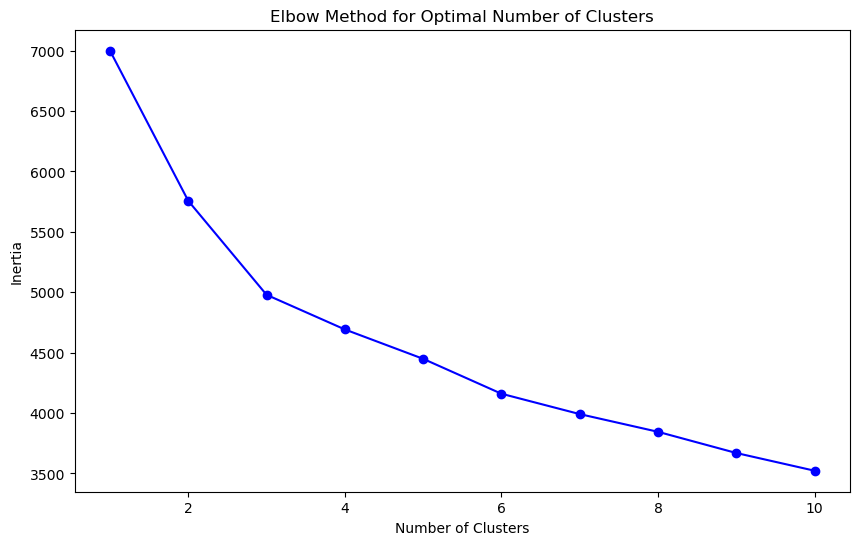

In [4]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 최적의 클러스터 수 찾기 (엘보우 방법)
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    inertia.append(kmeans.inertia_)

# 엘보우 그래프 생성
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()


엘보우 그래프를 통해 최적의 클러스터 수를 선택합니다. 예를 들어, 3개의 클러스터를 선택합니다.


In [7]:
# K-means 클러스터링 수행
kmeans = KMeans(n_clusters=3, random_state=42)
scaled_df['Cluster'] = kmeans.fit_predict(scaled_df)

# 클러스터링 결과 확인
scaled_df.groupby('Cluster').mean()

,PaidViewingRatio,FreeContentSearches,MonthlyFee,WatchingHours,Age,Region_Suburban,Region_Urban
Cluster,,,,,,,
0,0.033028,0.106571,-0.062202,0.116381,-0.019449,1.434609,-0.685994
1,0.027082,-0.093838,0.058300,-0.006254,0.049243,-0.697054,-0.685994
2,-0.063625,-0.005388,-0.000749,-0.112028,-0.034447,-0.697054,1.457738



### 클러스터 시각화

주요 변수들을 사용하여 클러스터링 결과를 시각화합니다.


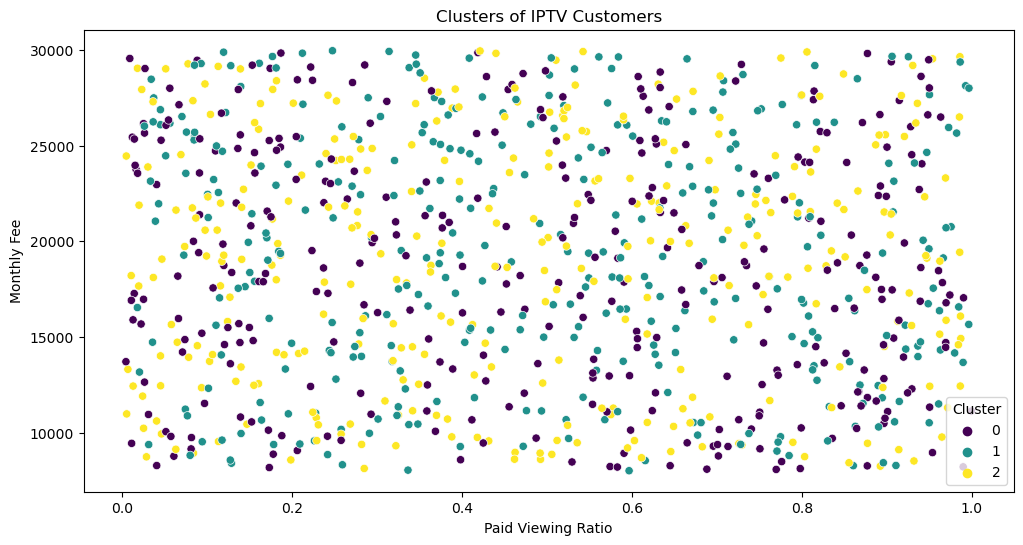

In [8]:
import seaborn as sns

# 클러스터별 시청 비중과 월 납부 요금 시각화
plt.figure(figsize=(12, 6))
sns.scatterplot(data=data, x='PaidViewingRatio', y='MonthlyFee', hue='Cluster', palette='viridis')
plt.title('Clusters of IPTV Customers')
plt.xlabel('Paid Viewing Ratio')
plt.ylabel('Monthly Fee')
plt.show()


### 분석을 통한 의사결정

이 분석을 통해 얻은 결과는 다양한 비즈니스 의사결정에 활용될 수 있습니다.

1. **고객 세분화**: 클러스터링 결과를 바탕으로 고객 그룹을 식별하여, 각 그룹에 맞춤형 마케팅 전략을 수립할 수 있습니다.
2. **프로모션 최적화**: 특정 클러스터에 속한 고객들에게 적합한 프로모션을 제공하여, 고객 만족도를 높이고 이탈을 방지할 수 있습니다.
3. **서비스 개선**: 각 클러스터의 특성을 분석하여, 서비스 품질을 개선하고 고객 경험을 향상시킬 수 있습니다.

이 노트북은 IPTV 고객 데이터를 사용하여 클러스터링을 수행하는 방법을 단계별로 설명합니다. 이를 통해 고객들을 그룹화하고, 각 그룹의 특성을 파악하여 효율적인 마케팅 전략을 수립하는 데 도움이 될 것입니다. 추가적으로, Kaggle, DataCamp, Medium 등의 자료를 참조하여 더 깊이 학습하는 것도 큰 도움이 됩니다.